# UNet

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.nn.functional import relu
from tqdm.auto import tqdm
import torch.optim as optim
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab, plot_predicted_image, plot_ab

/Users/mattiamartino/opt/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mattiamartino/opt/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /Users/mattiamartino/opt/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <A143545E-B078-3AE6-B77E-710940ED5873> /Users/mattiamartino/opt/anaconda3/envs/ML/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/mattiamartino/opt/anaconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not f

In [2]:
torch.backends.mps.is_available()

True

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

## Data import

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [5]:
path = '../train2014'
dataset = CocoDataset(path, transform=transform)

Found 82783 images.


In [6]:
image, l_channel, a_channel, b_channel, ab_channels = dataset[0]

In [7]:
image.shape, l_channel.shape, a_channel.shape, b_channel.shape, ab_channels.shape

(torch.Size([3, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([64, 64]),
 torch.Size([64, 64]),
 torch.Size([2, 64, 64]))

## Data preparation

In [8]:
test_size = int(.2 * len(dataset))
train_size = len(dataset) - test_size

In [9]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [10]:
for x in train_loader:
    print(len(x))
    print(f"Image shape {x[0].shape}\nL shape {x[1].shape}\nA shape {x[2].shape}\nB shape {x[3].shape}\nAB shape {x[4].shape}")
    break

5
Image shape torch.Size([64, 3, 64, 64])
L shape torch.Size([64, 1, 64, 64])
A shape torch.Size([64, 64, 64])
B shape torch.Size([64, 64, 64])
AB shape torch.Size([64, 2, 64, 64])


## UNet model

In [11]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

In [12]:
len(small_train), len(small_test)

(5000, 1000)

### Training

In [13]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the 
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [14]:
class UNet(nn.Module):
    def __init__(self, num_classes=2):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, 
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes, 
            kernel_size=1
        ) 
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        x = self.sigmoid(out)
        return x

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)

        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)

        self.conv10 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)

        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv14 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv15 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.up1 = nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, output_padding=1)

        self.conv16 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv17 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv18 = nn.Conv2d(512, 512, 3, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)

        self.conv19 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv20 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv21 = nn.Conv2d(256, 256, 3, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)

        self.conv22 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv23 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv24 = nn.Conv2d(128, 128, 3, padding=1)
        self.up4 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)

        self.conv25 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv26 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv27 = nn.Conv2d(64, 64, 3, padding=1)
        self.output = nn.Conv2d(64, 2, 1, padding=0)

    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x1 = F.leaky_relu(self.conv2(x1), negative_slope=0.2)
        x1 = F.leaky_relu(self.conv3(x1), negative_slope=0.2)
        x = self.maxpool1(x1)

        x2 = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x2 = F.leaky_relu(self.conv5(x2), negative_slope=0.2)
        x2 = F.leaky_relu(self.conv6(x2), negative_slope=0.2)
        x = self.maxpool2(x2)

        x3 = F.leaky_relu(self.conv7(x), negative_slope=0.2)
        x3 = F.leaky_relu(self.conv8(x3), negative_slope=0.2)
        x3 = F.leaky_relu(self.conv9(x3), negative_slope=0.2)
        x = self.maxpool3(x3)

        x4 = F.leaky_relu(self.conv10(x), negative_slope=0.2)
        x4 = F.leaky_relu(self.conv11(x4), negative_slope=0.2)
        x4 = F.leaky_relu(self.conv12(x4), negative_slope=0.2)
        x = self.maxpool4(x4)

        x = F.leaky_relu(self.conv13(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv14(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv15(x), negative_slope=0.2)
        x = self.up1(x)

        x = torch.cat([x4, x], dim=1)
        x = F.leaky_relu(self.conv16(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv17(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv18(x), negative_slope=0.2)
        x = self.up2(x)

        x = torch.cat([x3, x], dim=1)
        x = F.leaky_relu(self.conv19(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv20(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv21(x), negative_slope=0.2)
        x = self.up3(x)

        x = torch.cat([x2, x], dim=1)
        x = F.leaky_relu(self.conv22(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv23(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv24(x), negative_slope=0.2)
        x = self.up4(x)

        x = torch.cat([x1, x], dim=1)
        x = F.leaky_relu(self.conv25(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv26(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv27(x), negative_slope=0.2)
        x = self.output(x)

        return torch.sigmoid(x)

In [16]:
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
NUM_EPOCHS = 20
train_losses = []
test_losses = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss =  0.0

    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, _, _, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')

Epoch 1/20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 79/79 [02:12<00:00,  1.68s/it, loss=0.00327]


Epoch 1, Train Loss: 0.003274863700771445


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Epoch 1, Validation Loss: 0.0031121012434596196


Epoch 2/20: 100%|██████████| 79/79 [02:15<00:00,  1.71s/it, loss=0.00306]


Epoch 2, Train Loss: 0.0030645110726922374


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


Epoch 2, Validation Loss: 0.0030162307230057195


Epoch 3/20: 100%|██████████| 79/79 [02:15<00:00,  1.71s/it, loss=0.00306]


Epoch 3, Train Loss: 0.0030642721177184884


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


Epoch 3, Validation Loss: 0.0030168295052135363


Epoch 4/20: 100%|██████████| 79/79 [02:16<00:00,  1.72s/it, loss=0.00303]


Epoch 4, Train Loss: 0.00303288398876409


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 4, Validation Loss: 0.0029760941106360406


Epoch 5/20: 100%|██████████| 79/79 [02:16<00:00,  1.73s/it, loss=0.00302]


Epoch 5, Train Loss: 0.003015580554669605


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 5, Validation Loss: 0.002968658838653937


Epoch 6/20: 100%|██████████| 79/79 [02:22<00:00,  1.81s/it, loss=0.00302]


Epoch 6, Train Loss: 0.003024338190502758


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


Epoch 6, Validation Loss: 0.00298133421165403


Epoch 7/20: 100%|██████████| 79/79 [02:38<00:00,  2.00s/it, loss=0.00302]


Epoch 7, Train Loss: 0.003016572021230867


Testing: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 7, Validation Loss: 0.002960721292765811


Epoch 8/20: 100%|██████████| 79/79 [02:50<00:00,  2.16s/it, loss=0.003]  


Epoch 8, Train Loss: 0.003000034965409697


Testing: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


Epoch 8, Validation Loss: 0.0029867545963497832


Epoch 9/20: 100%|██████████| 79/79 [02:59<00:00,  2.27s/it, loss=0.00298]


Epoch 9, Train Loss: 0.0029821917267304054


Testing: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Epoch 9, Validation Loss: 0.0029371612617978826


Epoch 10/20: 100%|██████████| 79/79 [03:06<00:00,  2.36s/it, loss=0.00302]


Epoch 10, Train Loss: 0.0030212186872251804


Testing: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


Epoch 10, Validation Loss: 0.0029428006964735687


Epoch 11/20: 100%|██████████| 79/79 [03:05<00:00,  2.35s/it, loss=0.00301]


Epoch 11, Train Loss: 0.0030115528998872904


Testing: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Epoch 11, Validation Loss: 0.0029521923570428044


Epoch 12/20: 100%|██████████| 79/79 [03:11<00:00,  2.42s/it, loss=0.00298]


Epoch 12, Train Loss: 0.0029770637128525707


Testing: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


Epoch 12, Validation Loss: 0.002923003426985815


Epoch 13/20: 100%|██████████| 79/79 [04:12<00:00,  3.20s/it, loss=0.00298]


Epoch 13, Train Loss: 0.002981791426015051


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


Epoch 13, Validation Loss: 0.0028810990042984486


Epoch 14/20: 100%|██████████| 79/79 [02:14<00:00,  1.70s/it, loss=0.00294]


Epoch 14, Train Loss: 0.002936570642846106


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


Epoch 14, Validation Loss: 0.002898811289924197


Epoch 15/20: 100%|██████████| 79/79 [02:23<00:00,  1.82s/it, loss=0.00291]


Epoch 15, Train Loss: 0.002912072405879256


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


Epoch 15, Validation Loss: 0.0028836876299465075


Epoch 16/20: 100%|██████████| 79/79 [02:24<00:00,  1.83s/it, loss=0.00293]


Epoch 16, Train Loss: 0.002932768017407271


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


Epoch 16, Validation Loss: 0.0028611837624339387


Epoch 17/20: 100%|██████████| 79/79 [02:27<00:00,  1.87s/it, loss=0.00288]


Epoch 17, Train Loss: 0.0028835025916606944


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


Epoch 17, Validation Loss: 0.002919324077083729


Epoch 18/20: 100%|██████████| 79/79 [02:34<00:00,  1.95s/it, loss=0.00289]


Epoch 18, Train Loss: 0.0028854755631683372


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Epoch 18, Validation Loss: 0.002862813140382059


Epoch 19/20: 100%|██████████| 79/79 [02:35<00:00,  1.96s/it, loss=0.00285]


Epoch 19, Train Loss: 0.0028541677283665423


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 19, Validation Loss: 0.0028744716983055696


Epoch 20/20: 100%|██████████| 79/79 [02:36<00:00,  1.98s/it, loss=0.00288]


Epoch 20, Train Loss: 0.0028822615778050092


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Epoch 20, Validation Loss: 0.0028083255019737408
Finished Training


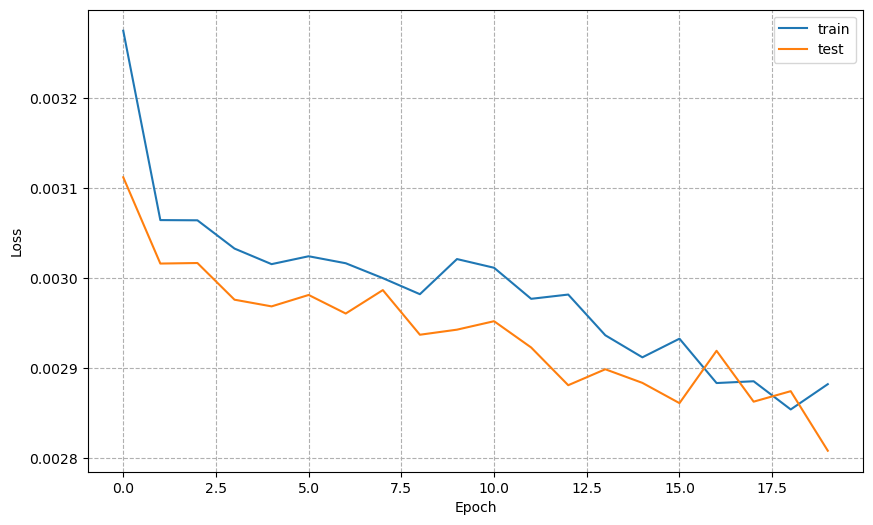

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

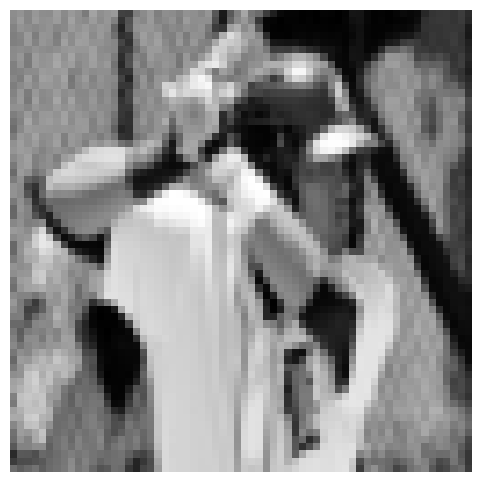

In [19]:
plot_l(dataset[0][1])

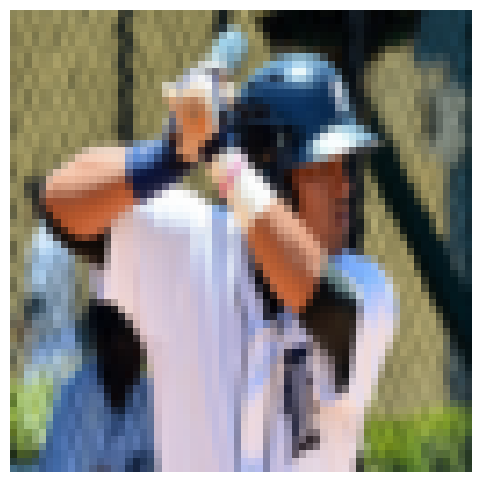

In [20]:
plot_rgb(dataset[0][0])

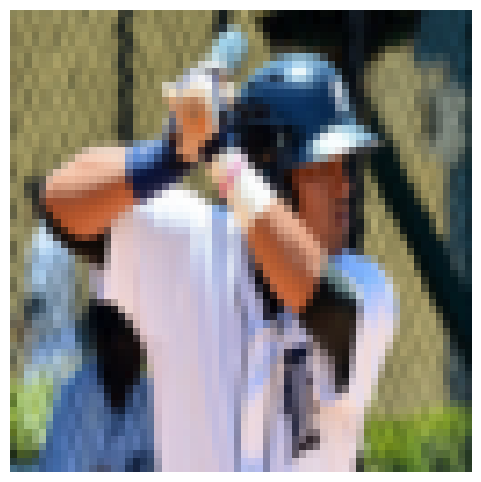

In [21]:
reconstruct_lab(dataset[0][1], dataset[0][-1])

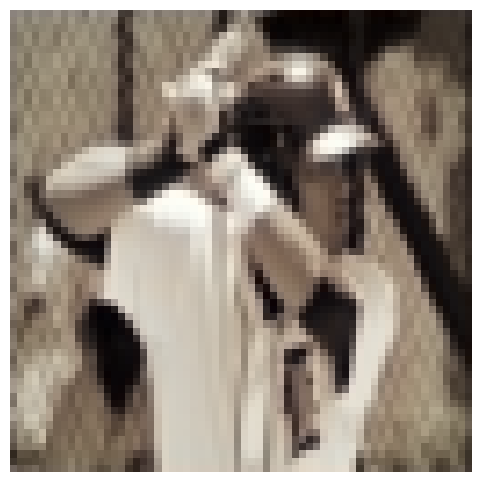

In [23]:
input = dataset[0][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[0][1].to(device).detach().cpu(), ab.detach().cpu())